# 1. Import

In [1]:
# %pip install dtaidistance

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt

# 2. 데이터 전처리

In [2]:
train = pd.read_csv('C:\\Project\\data-contest-lab\\competitions\\2025-kookmin-aibd\\00_setup\\data\\train.csv')

# 3. 데이터 탐색

In [3]:
print(train.shape)
train.head()
train.info()
train.isnull().sum()
train.nunique()

(10836, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 762.0+ KB


item_id      100
year           4
month         12
seq            3
type           1
hs4           71
weight      7438
quantity    1226
value       9686
dtype: int64

In [4]:
# 1) year-month 컬럼 생성
train["ym"] = pd.to_datetime(
    train["year"].astype(str) + "-" + train["month"].astype(str).str.zfill(2)
)

# 2) 월별 value 합산 (혹시 같은 item_id-year-month 조합이 여러 줄일 수 있으므로)
monthly = (
    train.groupby(["item_id", "ym"], as_index=False)["value"]
         .sum()
)

# 3) 피벗 생성: item_id × ym
pivot = monthly.pivot(index="item_id", columns="ym", values="value").fillna(0.0)

pivot.shape, pivot.head()

((100, 43),
 ym         2022-01-01   2022-02-01   2022-03-01   2022-04-01   2022-05-01  \
 item_id                                                                     
 AANGBULD      14276.0      52347.0      53549.0          0.0      26997.0   
 AHMDUILJ     242705.0     120847.0     197317.0     126142.0      71730.0   
 ANWUJOKX          0.0          0.0          0.0      63580.0      81670.0   
 APQGTRMF     383999.0     512813.0     217064.0     470398.0     539873.0   
 ATLDMDBO  143097177.0  103568323.0  118403737.0  121873741.0  115024617.0   
 
 ym        2022-06-01   2022-07-01  2022-08-01  2022-09-01  2022-10-01  ...  \
 item_id                                                                ...   
 AANGBULD     84489.0          0.0         0.0         0.0         0.0  ...   
 AHMDUILJ    149138.0     186617.0    169995.0    140547.0     89292.0  ...   
 ANWUJOKX     26424.0       8470.0         0.0         0.0     80475.0  ...   
 APQGTRMF    582317.0     759980.0    216019.

# 4. 공행성 쌍 찾기

In [6]:
# following 품목별 공행성 관계 개수
follower_stats = (
    pairs
    .assign(abs_corr=lambda df: df["max_corr"].abs())
    .groupby("following_item_id")
    .agg(
        n_leaders=("leading_item_id", "nunique"),
        max_abs_corr=("abs_corr", "max")
    )
    .sort_values("n_leaders", ascending=False)
)

follower_stats.head(10)


NameError: name 'pairs' is not defined

In [7]:
pairs_best = (
    pairs
    .assign(abs_corr=lambda df: df["max_corr"].abs())
    .sort_values("abs_corr", ascending=False)
    .drop_duplicates(subset=["following_item_id"])
)

pairs_best.shape, pairs_best.head()


NameError: name 'pairs' is not defined

In [32]:
# 이 중에서 진짜 상관계수 큰 TOP 5
top5 = pairs_best.sort_values("abs_corr", ascending=False).head(5)
top5

,leading_item_id,following_item_id,best_lag,max_corr,abs_corr
1299,XIIEJNEE,IGDVVKUD,4,0.928613,0.928613
1294,XIIEJNEE,DJBLNPNC,5,0.926700,0.926700
739,NAQIHUKZ,FTSVTTSR,1,0.905093,0.905093
742,NAQIHUKZ,LLHREMKS,3,0.894903,0.894903
138,BLANHGYY,BSRMSVTC,3,0.860032,0.860032


In [8]:
months = pivot.columns.to_list()
n_months = len(months)

x_idx = np.arange(n_months)  # 0,1,2,... 형태로 쓸 x축

for row in top5.itertuples(index=False):
    leader_id   = row.leading_item_id
    follower_id = row.following_item_id
    lag         = int(row.best_lag)
    corr        = row.max_corr

    leader_series   = pivot.loc[leader_id].values.astype(float)
    follower_series = pivot.loc[follower_id].values.astype(float)

    plt.figure(figsize=(10, 4))

    # leader는 원래 위치 그대로
    plt.plot(x_idx, leader_series, label=f"Leader {leader_id}")

    # follower는 lag만큼 밀어서 그림
    plt.plot(x_idx + lag, follower_series, label=f"Follower {follower_id} (shift, lag={lag})")

    # x축 눈금에 month 몇 개만 찍어주기 (간단 버전)
    step = max(1, n_months // 10)
    tick_pos = x_idx[::step]
    tick_labels = [months[i].strftime("%Y-%m") for i in tick_pos]
    plt.xticks(tick_pos, tick_labels, rotation=45)

    plt.title(f"Leader vs Follower (lag={lag}, corr={corr:.3f})")
    plt.xlabel("Month")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


NameError: name 'top5' is not defined

- 상관계수로 파악해보니 공행성이 전혀 드러나지 않음
    - 무역 데이터에서 흔히 발생하는 착시현상이라고 함
    - 특정 spike(팍 튀는) 현상이 발생하면 그때 corr 값이 높게 나옴
    - 거리 기반으로 다시 측정

In [28]:
def build_training_data_v2(pivot, pairs):
    months = pivot.columns.to_list()
    n_months = len(months)
    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        x = pivot.loc[leader].values.astype(float)
        y = pivot.loc[follower].values.astype(float)

        for t in range(lag+3, n_months-1):   # 최소 t-3까지 필요
            b_t      = y[t]
            b_t_1    = y[t-1]
            b_t_2    = y[t-2]
            b_t_3    = y[t-3]

            # follower 변화량
            diff_1   = b_t - b_t_1
            diff_2   = b_t_1 - b_t_2
            growth   = diff_1 / (b_t_1 + 1)

            # leader feature
            a_t_lag      = x[t-lag]
            a_t_lag_prev = x[t-lag-1] if (t-lag-1) >= 0 else 0
            a_growth     = (a_t_lag - a_t_lag_prev) / (a_t_lag_prev + 1)

            # log transform
            log_b_t      = np.log1p(b_t)
            log_a_t_lag  = np.log1p(a_t_lag)

            rows.append({
                "leading_item_id": leader,
                "following_item_id": follower,
                "b_t": b_t,
                "b_t_1": b_t_1,
                "b_t_2": b_t_2,
                "b_t_3": b_t_3,
                "diff_1": diff_1,
                "diff_2": diff_2,
                "growth": growth,
                "a_t_lag": a_t_lag,
                "a_growth": a_growth,
                "log_b_t": log_b_t,
                "log_a_t_lag": log_a_t_lag,
                "max_corr": corr,
                "best_lag": lag,
                "target": y[t+1],
                "t_idx": t
            })

    return pd.DataFrame(rows)

df_train = build_training_data_v2(pivot, pairs)
df_train.shape


(50468, 17)

In [29]:
df_train_best = df_train.merge(
    pairs_best[["leading_item_id", "following_item_id"]],
    on=["leading_item_id", "following_item_id"],
    how="inner"
)

df_train_best.shape, df_train.shape

((3210, 17), (50468, 17))

# 5. 회귀 모델 학습

In [31]:
t_max = df_train_best["t_idx"].max()
valid_border = t_max - 2   # 마지막 3개월을 valid

train_df_b = df_train_best[df_train_best["t_idx"] <= valid_border].copy()
valid_df_b = df_train_best[df_train_best["t_idx"] > valid_border].copy()

feature_cols = [
    "b_t", "b_t_1", "b_t_2", "b_t_3",
    "diff_1", "diff_2", "growth",
    "a_t_lag", "a_growth",
    "log_b_t", "log_a_t_lag",
    "max_corr", "best_lag",
]

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

train_X_b = train_df_b[feature_cols]
train_y_b = train_df_b["target"]
valid_X_b = valid_df_b[feature_cols]
valid_y_b = valid_df_b["target"]

# 1) 선형 회귀
lr_b = LinearRegression()
lr_b.fit(train_X_b, train_y_b)
pred_lr_b = lr_b.predict(valid_X_b)
rmse_lr_b = mean_squared_error(valid_y_b, pred_lr_b, squared=False)

# 2) CatBoost
cb_b = CatBoostRegressor(
    iterations=1200,
    depth=8,
    learning_rate=0.03,
    loss_function="RMSE",
    verbose=200,
    random_seed=42
)
cb_b.fit(train_X_b, train_y_b, eval_set=(valid_X_b, valid_y_b))
pred_cb_b = cb_b.predict(valid_X_b)
rmse_cb_b = mean_squared_error(valid_y_b, pred_cb_b, squared=False)

rmse_lr_b, rmse_cb_b


c:\Project\data-contest-lab\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0:	learn: 13764362.7922706	test: 12761003.7907580	best: 12761003.7907580 (0)	total: 5.69ms	remaining: 6.83s
200:	learn: 2432571.1233643	test: 3193669.5119174	best: 3165631.2441395 (146)	total: 923ms	remaining: 4.58s
400:	learn: 1733384.4841509	test: 3300440.4801842	best: 3165631.2441395 (146)	total: 1.76s	remaining: 3.51s
600:	learn: 1269034.2950358	test: 3292834.5126380	best: 3165631.2441395 (146)	total: 2.58s	remaining: 2.57s
800:	learn: 980819.2603870	test: 3261916.4658128	best: 3165631.2441395 (146)	total: 3.4s	remaining: 1.69s
1000:	learn: 770868.5058564	test: 3273035.8638109	best: 3165631.2441395 (146)	total: 4.3s	remaining: 856ms
1199:	learn: 628588.3112425	test: 3263809.3556775	best: 3165631.2441395 (146)	total: 5.17s	remaining: 0us

bestTest = 3165631.244
bestIteration = 146

Shrink model to first 147 iterations.


c:\Project\data-contest-lab\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(3588151.2053076425, 3165631.1760299387)

# 7. 거리 기반 공행성 찾기

In [9]:
def preprocess_series(series, smooth_window=3):
    s = np.array(series, dtype=float)

    # 1) log 변환
    s = np.log1p(s)

    # 2) diff 변환 (증감 패턴)
    s = np.diff(s, prepend=s[0])

    # 3) smoothing
    s = pd.Series(s).rolling(window=smooth_window, min_periods=1).mean().values

    # 4) normalization
    mean, std = s.mean(), s.std()
    if std == 0:
        return s * 0
    return (s - mean) / std

In [10]:
from dtaidistance import dtw

def find_comovement_pairs_dtw(pivot, max_lag=6):
    items = pivot.index.to_list()
    n_months = pivot.shape[1]
    results = []

    # 미리 모든 품목 시계열 전처리
    processed = {item: preprocess_series(pivot.loc[item].values) for item in items}

    for follower in items:
        best_leader = None
        best_lag = None
        best_score = 1e18  # DTW 거리 → 작을수록 좋음

        y = processed[follower]

        for leader in items:
            if leader == follower:
                continue

            x = processed[leader]

            # lag 1~6에 대한 DTW 최소 거리 찾기
            for lag in range(1, max_lag+1):
                if n_months <= lag:
                    continue

                # leader(t) vs follower(t+lag)
                x_cut = x[:-lag]
                y_cut = y[lag:]

                # 최소 길이 조건
                if len(x_cut) < 5:
                    continue

                dist = dtw.distance_fast(x_cut, y_cut)

                if dist < best_score:
                    best_score = dist
                    best_leader = leader
                    best_lag = lag

        results.append({
            "following_item_id": follower,
            "leading_item_id": best_leader,
            "best_lag": best_lag,
            "dtw_score": best_score
        })

    return pd.DataFrame(results)

pairs_dtw = find_comovement_pairs_dtw(pivot)
pairs_dtw.head()


,following_item_id,leading_item_id,best_lag,dtw_score
0,AANGBULD,QKXNTIIB,4,3.477343
1,AHMDUILJ,RCBZUSIM,5,3.617745
2,ANWUJOKX,SNHYOVBM,6,3.519237
3,APQGTRMF,UIFPPCLR,2,3.599959
4,ATLDMDBO,RCBZUSIM,6,3.302023


In [11]:
items = pivot.index.to_list()
months = pivot.columns.to_list()
n_months = len(months)

# 미리 전 품목 시계열 전처리
processed = {item: preprocess_series(pivot.loc[item].values) for item in items}

def find_pairs_dtw(pivot, max_lag=6):
    results = []
    for follower in items:
        y = processed[follower]

        best_leader = None
        best_lag = None
        best_score = 1e18

        for leader in items:
            if leader == follower:
                continue
            x = processed[leader]

            for lag in range(1, max_lag+1):
                if n_months <= lag:
                    continue

                x_cut = x[:-lag]
                y_cut = y[lag:]
                if len(x_cut) < 5:
                    continue

                dist = dtw.distance_fast(x_cut, y_cut)

                if dist < best_score:
                    best_score = dist
                    best_leader = leader
                    best_lag = lag

        results.append({
            "following_item_id": follower,
            "leading_item_id": best_leader,
            "best_lag": best_lag,
            "dtw_score": best_score,
        })
    return pd.DataFrame(results)

pairs_dtw = find_pairs_dtw(pivot)
pairs_dtw.sort_values("dtw_score").head()

,following_item_id,leading_item_id,best_lag,dtw_score
66,RJCAXSGH,KFQSHBNH,2,0.461653
41,KFQSHBNH,RJCAXSGH,3,0.466952
69,RUVXNNVA,GIKPEWTY,1,1.732696
28,GIKPEWTY,RUVXNNVA,1,1.732696
26,FTSVTTSR,UQYUIVVR,5,2.083856


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17312\2805956417.py:27: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17312\2805956417.py:27: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Project\data-contest-lab\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Project\data-contest-lab\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


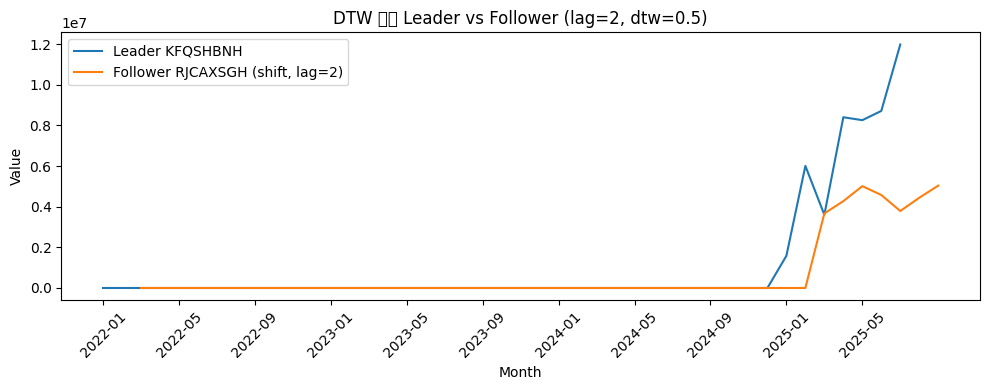

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17312\2805956417.py:27: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17312\2805956417.py:27: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Project\data-contest-lab\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Project\data-contest-lab\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


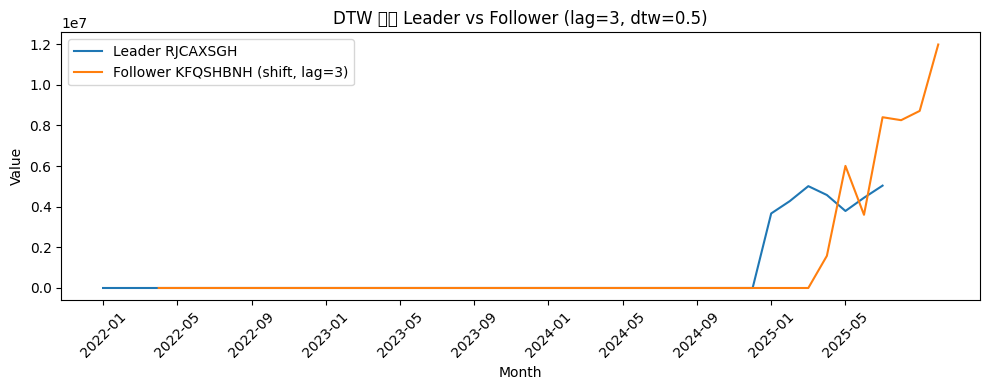

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17312\2805956417.py:27: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17312\2805956417.py:27: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Project\data-contest-lab\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Project\data-contest-lab\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


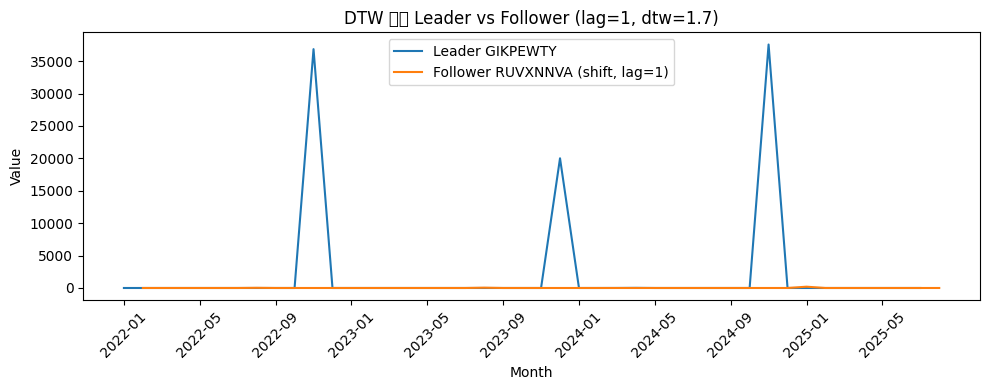

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17312\2805956417.py:27: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17312\2805956417.py:27: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Project\data-contest-lab\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Project\data-contest-lab\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


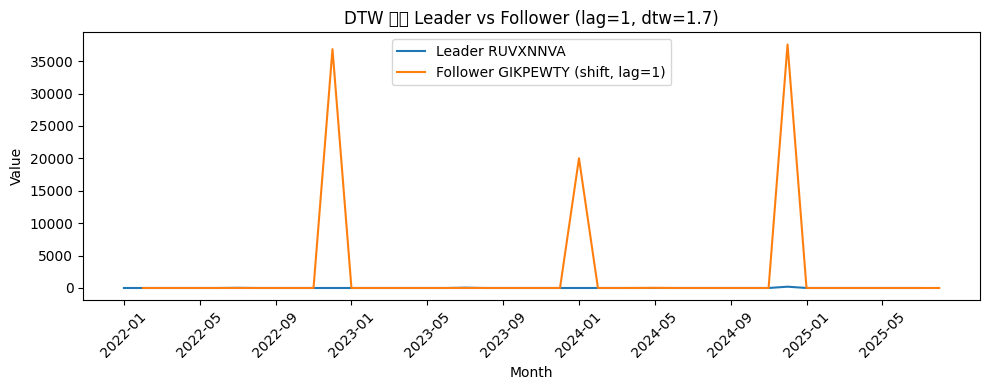

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17312\2805956417.py:27: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17312\2805956417.py:27: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Project\data-contest-lab\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Project\data-contest-lab\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


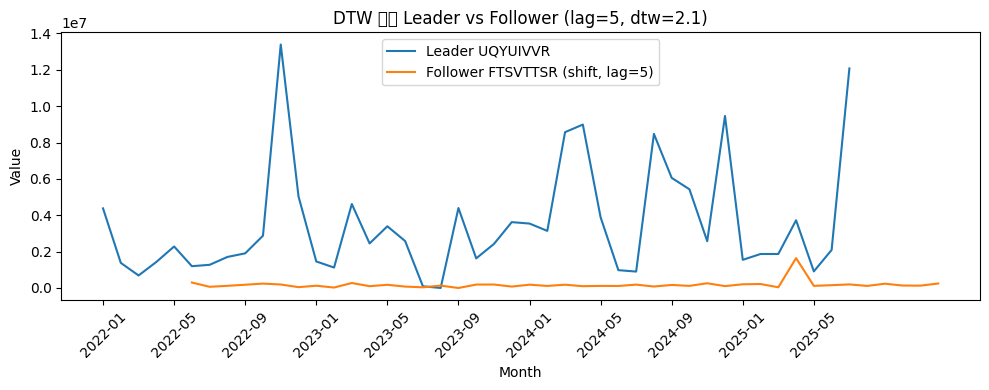

In [12]:
top5_dtw = pairs_dtw.sort_values("dtw_score").head(5)

x_idx = np.arange(n_months)

for row in top5_dtw.itertuples(index=False):
    leader_id   = row.leading_item_id
    follower_id = row.following_item_id
    lag         = int(row.best_lag)
    score       = row.dtw_score

    leader_series   = pivot.loc[leader_id].values.astype(float)
    follower_series = pivot.loc[follower_id].values.astype(float)

    plt.figure(figsize=(10, 4))
    plt.plot(x_idx, leader_series, label=f"Leader {leader_id}")
    plt.plot(x_idx + lag, follower_series, label=f"Follower {follower_id} (shift, lag={lag})")

    step = max(1, n_months // 10)
    tick_pos = x_idx[::step]
    tick_labels = [months[i].strftime("%Y-%m") for i in tick_pos]
    plt.xticks(tick_pos, tick_labels, rotation=45)

    plt.title(f"DTW 기반 Leader vs Follower (lag={lag}, dtw={score:.1f})")
    plt.xlabel("Month")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 8. Rolling(패턴 분할)

In [13]:
def rolling_corr(x, y, window=6):
    corr_vals = []
    for i in range(len(x) - window):
        xs = x[i:i+window]
        ys = y[i:i+window]
        corr = np.corrcoef(xs, ys)[0, 1]
        if not np.isnan(corr):
            corr_vals.append(corr)
    if len(corr_vals) == 0:
        return 0.0, 0.0, 0.0  # mean, min, max
    return np.mean(corr_vals), np.min(corr_vals), np.max(corr_vals)


In [14]:
from numpy.linalg import norm

def cosine_sim(a, b):
    denom = norm(a) * norm(b)
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)


In [15]:
def score_pair(x, y, lag):
    """
    x = leader preprocessed series
    y = follower preprocessed series
    """
    if lag >= len(x):
        return None  # invalid
    
    x_cut = x[:-lag]
    y_cut = y[lag:]

    if len(x_cut) < 10:
        return None
    
    # 1) DTW distance
    dist = dtw.distance_fast(x_cut, y_cut)

    # 2) Cosine similarity
    cos = cosine_sim(x_cut, y_cut)

    # 3) Rolling correlation
    rc_mean, rc_min, rc_max = rolling_corr(x_cut, y_cut, window=6)

    score = (
        (1 / (1 + dist)) * 0.45 +   # normalize dist → 높은게 좋게 변환
        (max(cos, 0)) * 0.35 +      # 음수이면 아예 효과 배제
        (max(rc_mean, 0)) * 0.20    # 안정성 반영
    )

    return score, dist, cos, rc_mean


In [16]:
def find_pairs_hybrid(pivot, max_lag=6):
    items = pivot.index.to_list()
    n_months = pivot.shape[1]

    processed = {item: preprocess_series(pivot.loc[item].values)
                 for item in items}

    results = []

    for follower in items:
        y = processed[follower]

        best_leader = None
        best_lag = None
        best_score = -1e18

        for leader in items:
            if leader == follower:
                continue
            
            x = processed[leader]

            # try lag 1~6
            for lag in range(1, max_lag+1):
                scored = score_pair(x, y, lag)
                if scored is None:
                    continue
                sc, dist, cos, rc_mean = scored

                if sc > best_score:
                    best_score = sc
                    best_leader = leader
                    best_lag = lag
                    best_det = (dist, cos, rc_mean)

        results.append({
            "following_item_id": follower,
            "leading_item_id": best_leader,
            "best_lag": best_lag,
            "hybrid_score": best_score,
            "dtw_dist": best_det[0],
            "cos_sim": best_det[1],
            "rolling_corr": best_det[2],
        })

    return pd.DataFrame(results)


In [17]:
pairs_hybrid = find_pairs_hybrid(pivot)
pairs_hybrid.sort_values("hybrid_score", ascending=False).head()


c:\Project\data-contest-lab\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Project\data-contest-lab\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,following_item_id,leading_item_id,best_lag,hybrid_score,dtw_dist,cos_sim,rolling_corr
41,KFQSHBNH,RJCAXSGH,1,0.631018,0.489443,0.690461,0.436149
66,RJCAXSGH,KFQSHBNH,1,0.618698,0.496667,0.643217,0.464518
26,FTSVTTSR,DEWLVASR,6,0.501675,2.555134,0.855218,0.378854
86,WBLJNPZQ,VWMBASNE,4,0.495380,3.575180,0.712342,0.738516
28,GIKPEWTY,GMBFCMIU,6,0.472244,5.916115,0.591938,1.000000


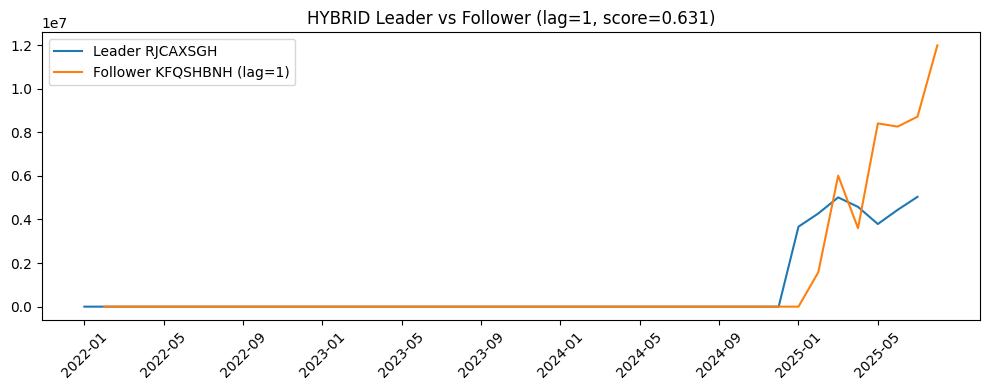

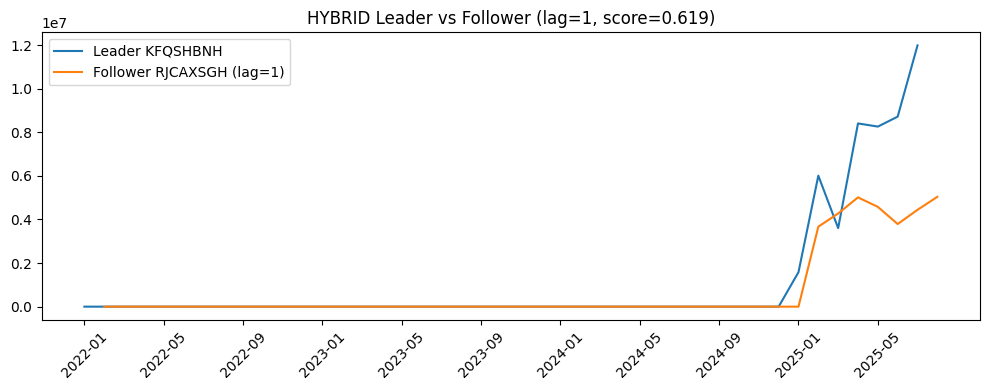

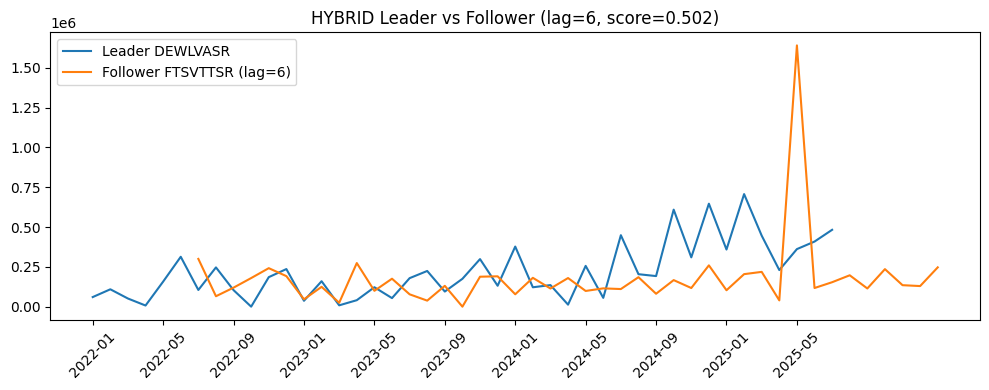

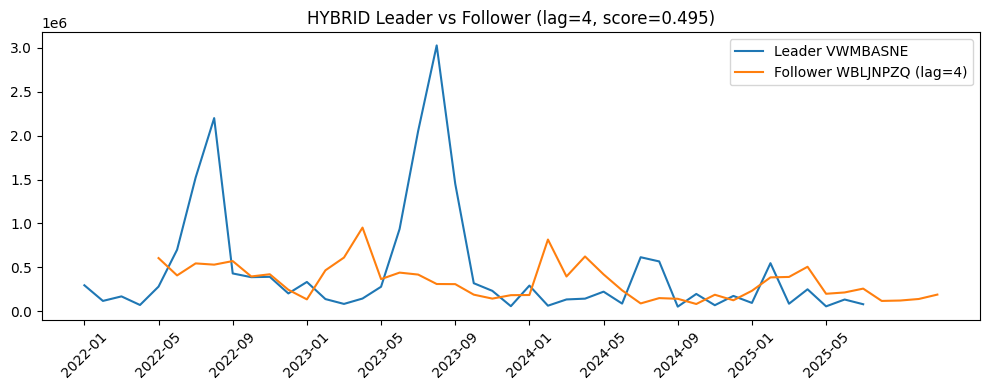

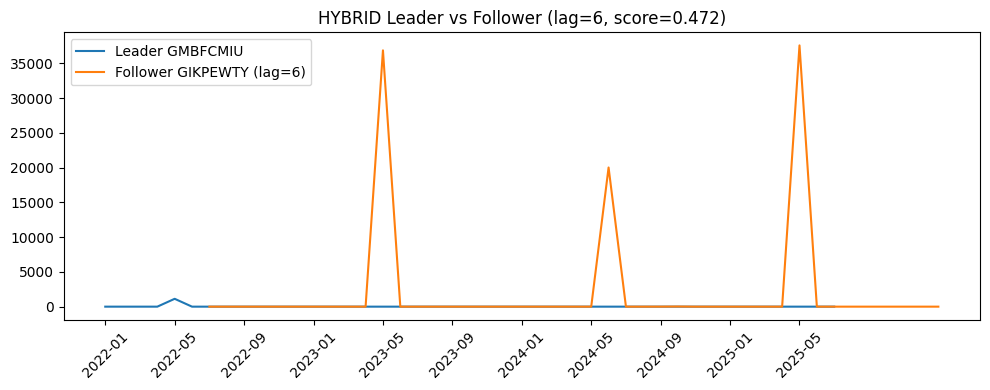

In [18]:
top5_hybrid = pairs_hybrid.sort_values("hybrid_score", ascending=False).head(5)

x_idx = np.arange(pivot.shape[1])
months = pivot.columns.to_list()

for row in top5_hybrid.itertuples(index=False):
    leader = row.leading_item_id
    follower = row.following_item_id
    lag = int(row.best_lag)
    score = row.hybrid_score

    leader_series = pivot.loc[leader].values
    follower_series = pivot.loc[follower].values

    plt.figure(figsize=(10,4))
    plt.plot(x_idx, leader_series, label=f"Leader {leader}")
    plt.plot(x_idx + lag, follower_series, label=f"Follower {follower} (lag={lag})")

    step = max(1, len(x_idx)//10)
    tick_pos = x_idx[::step]
    tick_labels = [months[i].strftime("%Y-%m") for i in tick_pos]
    plt.xticks(tick_pos, tick_labels, rotation=45)

    plt.title(f"HYBRID Leader vs Follower (lag={lag}, score={score:.3f})")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 8. 학습 데이터 만들기

In [19]:
items = pivot.index.to_list()
processed = {item: preprocess_series(pivot.loc[item].values) for item in items}
months = pivot.columns.to_list()
n_months = len(months)
t_last = n_months - 1  # 2025-07 위치

def score_all_pairs(pivot, max_lag=6):
    rows = []
    for leader in items:
        x = processed[leader]
        for follower in items:
            if follower == leader:
                continue
            y = processed[follower]

            best_lag = None
            best_score = -1e18
            best_det = None  # (dtw_dist, cos_sim, rolling_corr)

            for lag in range(1, max_lag+1):
                scored = score_pair(x, y, lag)
                if scored is None:
                    continue
                sc, dist, cos, rc_mean = scored
                if sc > best_score:
                    best_score = sc
                    best_lag = lag
                    best_det = (dist, cos, rc_mean)

            rows.append({
                "leading_item_id": leader,
                "following_item_id": follower,
                "best_lag": best_lag,
                "hybrid_score": best_score,
                "dtw_dist": best_det[0] if best_det else None,
                "cos_sim": best_det[1] if best_det else None,
                "rolling_corr": best_det[2] if best_det else None,
            })
    return pd.DataFrame(rows)

pairs_all = score_all_pairs(pivot)
pairs_all.head()

c:\Project\data-contest-lab\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Project\data-contest-lab\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,leading_item_id,following_item_id,best_lag,hybrid_score,dtw_dist,cos_sim,rolling_corr
0,AANGBULD,AHMDUILJ,6,0.182153,3.825270,0.203929,0.087594
1,AANGBULD,ANWUJOKX,4,0.241523,4.809669,0.310224,0.277439
2,AANGBULD,APQGTRMF,6,0.128862,5.263341,0.061768,0.176985
3,AANGBULD,ATLDMDBO,6,0.127560,4.074186,0.064024,0.082337
4,AANGBULD,AXULOHBQ,6,0.166040,4.492187,0.131487,0.190425


In [28]:
pairs_selected = pairs_all[pairs_all["hybrid_score"] >= 0.3].reset_index(drop=True)

pairs_selected.head(), pairs_selected["leading_item_id"].nunique()


(  leading_item_id following_item_id  best_lag  hybrid_score  dtw_dist  \
 0        AANGBULD          DJBLNPNC         2      0.362186  4.550605   
 1        AANGBULD          HCDTGMST         2      0.304629  4.355384   
 2        AANGBULD          JSLXRQOK         6      0.316940  4.032028   
 3        AANGBULD          KJNSOAHR         5      0.354336  4.457839   
 4        AANGBULD          NZKBIBNU         3      0.306504  4.975469   
 
     cos_sim  rolling_corr  
 0  0.469772      0.583467  
 1  0.407704      0.389522  
 2  0.413359      0.414183  
 3  0.452657      0.567279  
 4  0.429054      0.405135  ,
 100)

In [21]:
feature_cols = [
    "b_t", "b_t_1", "b_t_2", "b_t_3",
    "diff_1", "diff_2", "growth",
    "a_t_lag", "a_growth",
    "log_b_t", "log_a_t_lag",
    "hybrid_score", "dtw_dist", "cos_sim", "rolling_corr",
    "best_lag",
]

def make_features_from_row(row):
    leader_id = row["leading_item_id"]
    follower_id = row["following_item_id"]
    lag = int(row["best_lag"])

    x = pivot.loc[leader_id].values.astype(float)    # leader
    y = pivot.loc[follower_id].values.astype(float)  # follower

    t = t_last  # 2025-07

    if t - 3 < 0 or t - lag < 0:
        return None

    b_t   = y[t]
    b_t_1 = y[t-1]
    b_t_2 = y[t-2]
    b_t_3 = y[t-3]

    diff_1 = b_t - b_t_1
    diff_2 = b_t_1 - b_t_2
    growth = diff_1 / (b_t_1 + 1)

    a_t_lag = x[t-lag]
    a_t_lag_prev = x[t-lag-1] if (t-lag-1) >= 0 else 0.0
    a_growth = (a_t_lag - a_t_lag_prev) / (a_t_lag_prev + 1)

    log_b_t = np.log1p(b_t)
    log_a_t_lag = np.log1p(a_t_lag)

    return {
        "b_t": b_t,
        "b_t_1": b_t_1,
        "b_t_2": b_t_2,
        "b_t_3": b_t_3,
        "diff_1": diff_1,
        "diff_2": diff_2,
        "growth": growth,
        "a_t_lag": a_t_lag,
        "a_growth": a_growth,
        "log_b_t": log_b_t,
        "log_a_t_lag": log_a_t_lag,
        "hybrid_score": row["hybrid_score"],
        "dtw_dist": row["dtw_dist"],
        "cos_sim": row["cos_sim"],
        "rolling_corr": row["rolling_corr"],
        "best_lag": lag,
    }


In [22]:
def build_training_data_hybrid(pivot, pairs_hybrid):
    """
    Hybrid 공행성 기반 학습 데이터 생성
    pivot: item_id × month value matrix
    pairs_hybrid: 각 follower의 최적 leader + lag + hybrid score 정보
    """
    months = pivot.columns.to_list()
    n_months = len(months)
    rows = []

    for row in pairs_hybrid.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)

        hybrid_score = float(row.hybrid_score)
        dtw_dist = float(row.dtw_dist)
        cos_sim = float(row.cos_sim)
        rolling_corr = float(row.rolling_corr)

        # 원시 시계열
        x = pivot.loc[leader].values.astype(float)    # leader 시계열
        y = pivot.loc[follower].values.astype(float)  # follower 시계열

        # 타임 스텝 반복
        # target은 y[t+1] → 그러므로 t는 n_months - 2 까지
        # feature 만들려면 최소 y[t-3], x[t-lag] 필요
        start_t = max(3, lag + 1)
        end_t = n_months - 2  # target = y[t+1] 위한 제약

        for t in range(start_t, end_t + 1):
            # follower 쪽 features
            b_t   = y[t]
            b_t_1 = y[t-1]
            b_t_2 = y[t-2]
            b_t_3 = y[t-3]

            diff_1 = b_t - b_t_1
            diff_2 = b_t_1 - b_t_2
            growth = diff_1 / (b_t_1 + 1)

            # leader 쪽 features
            a_t_lag = x[t - lag]
            a_t_lag_prev = x[t - lag - 1] if (t - lag - 1) >= 0 else 0.0
            a_growth = (a_t_lag - a_t_lag_prev) / (a_t_lag_prev + 1)

            log_b_t = np.log1p(b_t)
            log_a_t_lag = np.log1p(a_t_lag)

            # target
            target = y[t + 1]

            rows.append({
                "leading_item_id": leader,
                "following_item_id": follower,

                "b_t": b_t,
                "b_t_1": b_t_1,
                "b_t_2": b_t_2,
                "b_t_3": b_t_3,
                "diff_1": diff_1,
                "diff_2": diff_2,
                "growth": growth,

                "a_t_lag": a_t_lag,
                "a_growth": a_growth,

                "log_b_t": log_b_t,
                "log_a_t_lag": log_a_t_lag,

                "hybrid_score": hybrid_score,
                "dtw_dist": dtw_dist,
                "cos_sim": cos_sim,
                "rolling_corr": rolling_corr,
                "best_lag": lag,

                "target": target,
                "t_idx": t,
            })

    return pd.DataFrame(rows)

In [29]:
df_train_h = build_training_data_hybrid(pivot, pairs_hybrid)
df_train_h.shape
df_train_h.head()

,leading_item_id,following_item_id,b_t,b_t_1,b_t_2,b_t_3,diff_1,diff_2,growth,a_t_lag,a_growth,log_b_t,log_a_t_lag,hybrid_score,dtw_dist,cos_sim,rolling_corr,best_lag,target,t_idx
0,RJGPVEXX,AANGBULD,0.0,53549.0,52347.0,14276.0,-53549.0,1202.0,-0.999981,181873.0,-0.675724,0.000000,12.111069,0.407416,4.296235,0.597535,0.566566,2,26997.0,3
1,RJGPVEXX,AANGBULD,26997.0,0.0,53549.0,52347.0,26997.0,-53549.0,26997.000000,569851.0,2.133224,10.203518,13.253132,0.407416,4.296235,0.597535,0.566566,2,84489.0,4
2,RJGPVEXX,AANGBULD,84489.0,26997.0,0.0,53549.0,57492.0,26997.0,2.129491,389516.0,-0.316459,11.344388,12.872663,0.407416,4.296235,0.597535,0.566566,2,0.0,5
3,RJGPVEXX,AANGBULD,0.0,84489.0,26997.0,0.0,-84489.0,57492.0,-0.999988,446445.0,0.146153,0.000000,13.009074,0.407416,4.296235,0.597535,0.566566,2,0.0,6
4,RJGPVEXX,AANGBULD,0.0,0.0,84489.0,26997.0,0.0,-84489.0,0.000000,428694.0,-0.039761,0.000000,12.968501,0.407416,4.296235,0.597535,0.566566,2,0.0,7


In [30]:
X_full = df_train_h[feature_cols]
y_full = df_train_h["target"]

In [31]:
from catboost import CatBoostRegressor

final_cb = CatBoostRegressor(
    iterations=1200,
    depth=8,
    learning_rate=0.03,
    loss_function="RMSE",
    random_seed=42,
    verbose=200,
)

final_cb.fit(X_full, y_full)

0:	learn: 12691420.5844313	total: 21.8ms	remaining: 26.1s
200:	learn: 2182145.6593669	total: 1.87s	remaining: 9.29s
400:	learn: 1617151.5190787	total: 3.12s	remaining: 6.21s
600:	learn: 1252900.2171691	total: 4.43s	remaining: 4.41s
800:	learn: 980396.3004541	total: 5.73s	remaining: 2.85s
1000:	learn: 792160.0373877	total: 6.97s	remaining: 1.39s
1199:	learn: 641426.9651238	total: 8.3s	remaining: 0us


In [32]:
test_feats = []
pair_index = []

for r in pairs_selected.itertuples(index=False):
    row_dict = r._asdict()
    feat = make_features_from_row(row_dict)
    if feat is None:
        continue
    test_feats.append(feat)
    pair_index.append(row_dict)

X_test = pd.DataFrame(test_feats)[feature_cols]

preds = final_cb.predict(X_test)
preds = np.clip(preds, 0, None)  # 음수 방지


In [33]:
rows_out = []
for info, p in zip(pair_index, preds):
    rows_out.append({
        "leading_item_id": info["leading_item_id"],
        "following_item_id": info["following_item_id"],
        "value": p,   # 정수 필요하면 int(round(p))
    })

sub_df = pd.DataFrame(rows_out)
sub_df.to_csv("submission_hybrid_leader_top3.csv", index=False)
print(sub_df.head())
print("submission_hybrid_leader_top3.csv 저장 완료")


  leading_item_id following_item_id         value
0        AANGBULD          DJBLNPNC  5.369123e+04
1        AANGBULD          HCDTGMST  1.744744e+06
2        AANGBULD          JSLXRQOK  3.820405e+06
3        AANGBULD          KJNSOAHR  1.211361e+07
4        AANGBULD          NZKBIBNU  4.466275e+06
submission_hybrid_leader_top3.csv 저장 완료
